# Tiempo

Vamos a hacer un poco de estadística del tiempo que toma etiquetar artículos

In [1]:
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article
from django.contrib.auth.models import User

Quedémonos sólo con los que tienen algo de metadata **y hayan sido marcados como interesantes**

In [2]:
from collections import defaultdict

labels = defaultdict(list)

for article_label in ArticleLabel.objects.all():
    if article_label.metadata and article_label.is_interesting:
        labels[article_label.user.username].append(article_label)

In [3]:
import json

json.loads(labels["mkondra"][0].metadata)

{'start_time': '2020-11-02T17:52:45.736Z',
 'opened_article': False,
 'end_time': '2020-11-02T17:59:05.658Z'}

In [6]:
import json
from datetime import datetime

times = defaultdict(list)

for user, user_labels in labels.items():
    for label in user_labels:
        metadata = json.loads(label.metadata)
        end = datetime.strptime(metadata["end_time"], '%Y-%m-%dT%H:%M:%S.%fZ')
        start = datetime.strptime(metadata["start_time"], '%Y-%m-%dT%H:%M:%S.%fZ')

        times[label.user.username].append((end - start).seconds)
        

<AxesSubplot:ylabel='Count'>

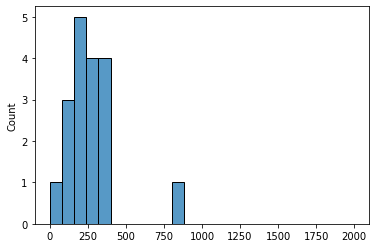

In [7]:
import seaborn as sns

sns.histplot(times["mkondra"], binrange=[0, 2000], bins=25)

<AxesSubplot:ylabel='Count'>

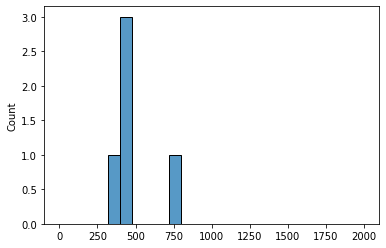

In [9]:
import seaborn as sns

sns.histplot(times["fluque"], binrange=[0, 2000], bins=25)

<AxesSubplot:ylabel='Count'>

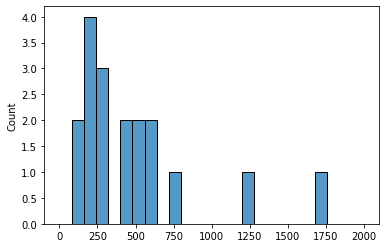

In [8]:
import seaborn as sns

sns.histplot(times["jzajac"], binrange=[0, 2000], bins=25)

<AxesSubplot:ylabel='Count'>

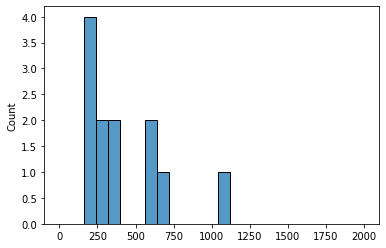

In [73]:
import seaborn as sns

sns.histplot(times["amoro"], binrange=[0, 2000], bins=25)

<AxesSubplot:ylabel='Count'>

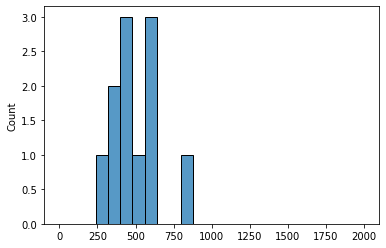

In [74]:
import seaborn as sns

sns.histplot(times["ndebandi"], binrange=[0, 2000], bins=25)

In [12]:
import numpy as np

for user in times:
    print(user)
    print(np.array(times[user]).mean())
    print(len(times[user]))

mkondra
384.63157894736844
19
jzajac
1223.4347826086957
23
ndebandi
622.25
12
pserrati
318.0
3
fluque
489.0
5
amoro
423.9166666666667
12
dzayat
592.6666666666666
3


Hagamos una cosa: tomemos todos los tiempos menores a 1000 segundos (~16 minutos) y promediemos eso

## Estimación

Supongamos que queremos etiquetar 1000 artículos

Asumiendo que tenemos 3 etiquetadores, y asumiendo peor caso (cada artículo es etiquetado 3 veces) => sampleemos 1000 artículos para cada etiquetador

In [19]:
import numpy as np

users = ["ndebandi", "mkondra", "jzajac", "fluque", "amoro"]

times_needed = defaultdict(list)

for user in users:
    times_less_than_1000 = [t for t in times[user] if t < 1000]
    times_needed[user] = np.random.choice(times_less_than_1000, 600)

In [20]:
total_per_user = {u: sum(v) for u, v in times_needed.items()}

total_per_user

{'ndebandi': 291929,
 'mkondra': 154968,
 'jzajac': 220345,
 'fluque': 283149,
 'amoro': 213719}

In [21]:
sum(total_per_user.values()) / 3600

323.3638888888889

Necesitaríamos 306 horas. Yo le pondría un extra, ya que me parece que los etiquetadores van a tardar un poco más => pongamos 400 horas
